# CMS-COR-SAP. Exercise 7
By *Oleh Shkalikov*

In [1]:
import scipy as sc
import numpy as np
from scipy import stats
from itertools import product

from matplotlib import pyplot as plt

## Stationary Distributions
A stationary distribution $\pi$ of a transition matrix $P$ has the property $\pi P = \pi$, which means
that the distribution $\pi$ is invariant with respect to the transition kernel P.

Find the stationary distribution $\pi$ of the transition matrix $P$ by solving for the non-zero
vector that satisfies the equation $\pi P = \pi$

In [2]:
P1 = np.array([[0.6, 0.2, 0.2],
               [0.3, 0.1, 0.6],
               [0.5, 0.2, 0.3]])

Let's come up with linear equations system for the $\pi$
$$
\pi P = \pi \implies \pi(P - I) = 0 \implies (P-I)^T \pi^T = 0
$$
But the rank of this matrix less than 3. On the other hand we have condition, that the sum of components of $\pi$ equals to 1, so we can use it as 3 equation in the system:

$$
\begin{pmatrix}
    -0.4 & 0.3 & 0.5 \\
    0.2 & -0.9 & 0.2 \\
    1 & 1 & 1
\end{pmatrix} \pi^T = 
\begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}
$$

In [3]:
A = np.concatenate([(P1 - np.eye(3))[:, :2], np.ones((3, 1))], axis=1).T
np.linalg.solve(A, [0, 0, 1])

array([0.51515152, 0.18181818, 0.3030303 ])

But there is an other way to compute this stationary distribution.
Actually, we have to find the normalized **left** eigenvector which corresponds to the eigenvalue $1$

In [4]:
eigvals, eigv = sc.linalg.eig(P1, left=True, right=False)

In [5]:
eigvals

array([ 1. +0.j,  0.1+0.j, -0.1+0.j])

In [6]:
pst1 = eigv[:, 0]
pst1 = pst1 / np.sum(pst1)
pst1

array([0.51515152, 0.18181818, 0.3030303 ])

You can also determine the stationary distribution by finding the limiting distribution.
Start from any distribution and apply the transition kernel many times until the distribution converges. Solve the problem by iteratively multiplying the transition
matrix from an arbitrary initial distribution $[0.3, 0, 0.7]^T$ five times and observe the
distribution converge to $\pi$.

In [7]:
np.linalg.matrix_power(P1, 5)

array([[0.51516, 0.18182, 0.30302],
       [0.51513, 0.18181, 0.30306],
       [0.51515, 0.18182, 0.30303]])

## Detailed Balance

A transition matrix has detailed balance if the following condition is satisfied:

$$
    P_{i,j} \pi(x_i) = P_{j, i} \pi(x_j)
$$ 

In [8]:
def check_detailed_balance(P, pst):
    for i, j in product(range(P.shape[0]), range(P.shape[0])):        
        if not np.allclose(P[i, j] * pst[i], P[j, i] * pst[j]):
            return False
    return True            

Does the transition matrix with its stationary distribution in the first task have detailed balance?

In [9]:
check_detailed_balance(P1, pst1)

False

Does the transition matrix $P_2$ and its stationary distribution $\pi_2$ below follow detailed
balance?

In [10]:
P2 = np.array([[0.2, 0.4, 0.4], 
              [0.1, 0.6, 0.3], 
              [0.2, 0.6, 0.2]])
pst2 = np.array([1/7, 4/7, 2/7])

In [11]:
check_detailed_balance(P2, pst2)

True

## Gibbs Sampling

Gibbs sampling is used to sample from a joint multivariate distribution indirectly by sampling from its conditional distributions. This is advantageous if the joint distribution is
difficult to sample from as compared to its full conditional distributions.

Let’s imagine that we can easily draw samples from the conditional distributions of a bivariate normal distribution with a mean vector ($\mu$) and covariance matrix ($\Sigma$) given
below, but not its joint distribution.

$$ 
\mu = \begin{pmatrix}
    3 \\ 2
\end{pmatrix} \qquad
\Sigma = \begin{pmatrix}
    4 & 3 \\
    3 & 9
\end{pmatrix}
$$

The conditional distributions conveniently turn out to be univariate normal distributions:
$$
X|Y \sim N(3 + \frac{1}{3} (y - 2), 3)
$$
$$
Y|X \sim N(2 + \frac{3}{4} (x - 3), \frac{27}{4})
$$

Draw 1000 samples from the joint distribution from the bivariate normal distribution using
Gibbs sampling. Check if you are able to accurately sample from the joint distribution
by overlaying the samples on a plot of the actual bivariate normal distribution PDF.

In [12]:
def mcmc_gibbs(n, n_burn=0):
    result = np.empty((n, 2))

    xlast = np.empty(2)        
    xlast[1] = stats.norm.rvs(size=1, loc=2, scale=3)
    
    for i in range(n_burn):
        xlast[0] = stats.norm.rvs(size=1, loc=3 + 1/3 * (xlast[1] - 2), scale=np.sqrt(3))
        xlast[1] = stats.norm.rvs(size=1, loc=2 + 3/4 * (xlast[0] - 3), scale=np.sqrt(27/4))

    for i in range(n):
        xlast[0] = stats.norm.rvs(size=1, loc=3 + 1/3 * (xlast[1] - 2), scale=np.sqrt(3))
        xlast[1] = stats.norm.rvs(size=1, loc=2 + 3/4 * (xlast[0] - 3), scale=np.sqrt(27/4))
        result[i] = xlast

    return result

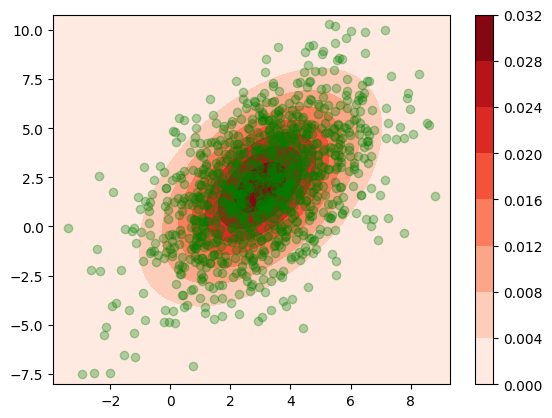

In [13]:
samples = mcmc_gibbs(1000, 10)

x1 = np.min(samples[:, 0]) - 0.5
x2 = np.max(samples[:, 0]) + 0.5
y1 = np.min(samples[:, 1]) - 0.5
y2 = np.max(samples[:, 1]) + 0.5

x, y = np.mgrid[x1:x2:.01, y1:y2:.01]
points = np.dstack((x, y))
density = stats.multivariate_normal.pdf(points, mean=np.array([3, 2]), cov=np.array([[4, 3], [3, 9]]))
c = plt.contourf(x, y, density, cmap='Reds')
plt.colorbar(c)

plt.scatter(samples[:, 0], samples[:, 1], color='green', alpha=0.3);